# Analysing the Stock Market with Python

This notebook mainly explains how to import stocks price data from Yahoo Finance, calculate your portfolio performance, and other **interesting** stuff.

Detailed contents:
* download data from yahoo finance using stocknames example ['MSFT', 'AAPL']
* plot normalised graphs, ie, starting at 1 for all
* daily returns ratio = df.pct_change()
* correlations: daily_returns.corr()
* cumulative returns ratio: profit/loss ratio
* Sharpe ratio
* daily portfolio value (DPV) for example allocationa: Port1[20% MSFT, 80% APPL] AND Port2[70% MSFT, 30% AAPL]
* candles chart

In [1]:
#libraries prerequisite
!pip install yfinance
!pip install mplfinance
!pip install plotly --user
!pip install seaborn
!pip install statsmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 418.4 kB/s eta 0:00:00


In [2]:
#Adding Comment from VS Code

import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from plotly import express as px
import datetime as dt
import os

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 10000

--------------------------------------------------------------
# *Download Data from* <font color='purple'>Yahoo!</font>
Option 1- Using `yf.download` (Recommended)<br>
Option 2- Using `yf.Ticker(['list of stock names']).history('args')`<br>
Option 3- Using `pandas_data_reader`<br>

[List of SP500 Companies](https://www.liberatedstocktrader.com/sp-500-companies/)

*Define stock names, Start date, End date, and interval*

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

stocknames = ['AAPL', 'MSFT']    #ticker
startdate = '2019-01-01'
enddate = '2023-12-31'
# enddate =   dt.datetime.now().date()    #change to current day date if required
interval = '1d'

downloading data using Using yf.download (Recommended)

In [4]:
for stock in stocknames:
    df = yf.download(stock, interval=interval, period='max')
    df.to_csv('stocks_data\\{}.csv'.format(stock))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


downloading data using Using yf.Ticker(['list of stock names']).history('args')

In [5]:
def appending(cols=[], startdate='', enddate=''):
    '''append stocks data into one file and then select the 'Adj Close' column'''
    dates = pd.date_range(start=startdate, end=enddate)
    df = pd.DataFrame(index=dates)
    for stock in stocknames:
        df_stock = pd.read_csv('stocks_data\\{}.csv'.format(stock), index_col='Date', parse_dates=True, usecols=cols, na_values=['NaN'])
        df_stock = df_stock.rename(columns = {'Adj Close': stock})
        df = df.join(df_stock)
        df = df.loc[dates]
    df.index.names = ['Date']
    df = df.dropna()    #there are other ways to handle missing values. For simplicity, drop them for now
    return df

df = appending(['Date', 'Adj Close'], startdate, enddate)
print(df)

              AAPL    MSFT
Date                      
2019-01-02  37.845  95.846
2019-01-03  34.075  92.320
2019-01-04  35.530  96.614
2019-01-07  35.451  96.737
2019-01-08  36.127  97.438
...            ...     ...
2023-12-22 193.353 373.889
2023-12-26 192.804 373.968
2023-12-27 192.904 373.380
2023-12-28 193.333 374.587
2023-12-29 192.285 375.346

[1258 rows x 2 columns]


### *Global Statistics:*

In [6]:
df_desc = df.describe().T
df_desc[['count', 'mean', 'std', 'min', '50%', 'max']]

,count,mean,std,min,50%,max
AAPL,"1,258.000",121.414,46.759,34.075,132.489,197.858
MSFT,"1,258.000",231.344,73.322,92.320,238.995,381.994


### A Quick look at the prices

In [7]:
from plotly import express as px

px.line(data_frame=df, title='Tickers Adj. Close Prices', width=1000, height=500)

--------------------------------------------------------------
We need to observe the `relative stock movement`, i.e. how much the stock went up or down compared to the other stocks. Therefore we need to **`Normalize`** the stock prices to start with $1.

To do this we will ***divide the prices of each column by Day-One-Price***.<br>
$$Norm = df / df.iloc[0,:]$$

In [8]:
df.head()

,AAPL,MSFT
Date,,
2019-01-02,37.845,95.846
2019-01-03,34.075,92.320
2019-01-04,35.530,96.614
2019-01-07,35.451,96.737
2019-01-08,36.127,97.438


In [9]:
norm = df / df.iloc[0,:]
norm.head()

,AAPL,MSFT
Date,,
2019-01-02,1.000,1.000
2019-01-03,0.900,0.963
2019-01-04,0.939,1.008
2019-01-07,0.937,1.009
2019-01-08,0.955,1.017


Plot the normalized graphs using plotly

In [10]:
fig = px.line(norm, x=norm.index, y=['MSFT', 'AAPL'])
fig.update_layout(title='Stock movement observation by normalizing Adj close prices, (Daily Cumulative Return)',
                  xaxis_title='Date',
                  yaxis_title='Normalized price')
fig.show()

Plot the normalized graphs using pandas dataframe plot function (same output)

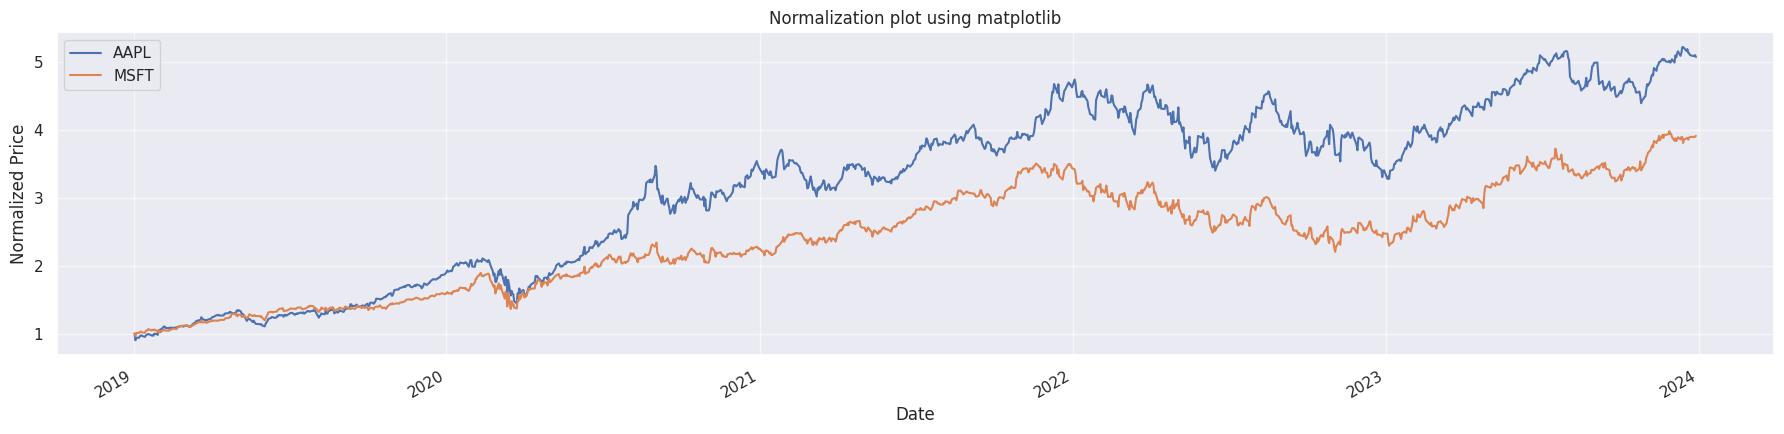

In [11]:
from matplotlib import pyplot as plt

norm.plot(figsize=(18, 4.5))
plt.grid(alpha=0.6)
plt.title('Normalization plot using matplotlib')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.tight_layout()

### *Rolling Statistics*

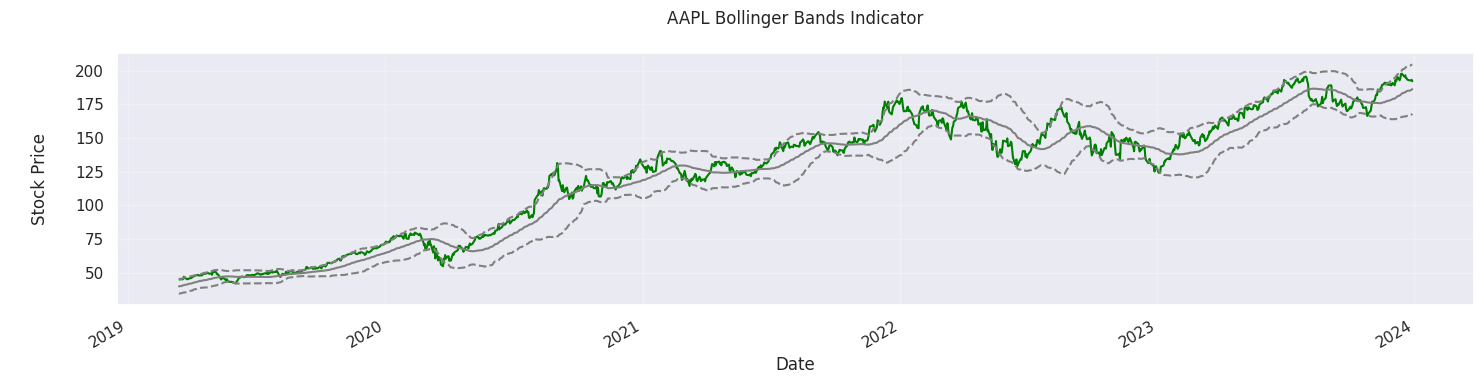

In [12]:
rollingmean = df.AAPL.rolling(50).mean()
rollingstd = df.AAPL.rolling(50).std()
lowerbound = rollingmean - (2 * rollingstd)
upperbound = rollingmean + (2 * rollingstd)
fig, ax = plt.subplots(figsize=(15,4))
df.iloc[50:]['AAPL'].plot(ax=ax, color='green')
ax.set_title('AAPL Bollinger Bands Indicator\n')
ax.set_xlabel('Date')
ax.set_ylabel('\nStock Price\n')
rollingmean.plot(ax=ax, linestyle='-', color='grey')
lowerbound.plot(ax=ax, linestyle='--', color='grey')
upperbound.plot(ax=ax, linestyle='--', color='grey')
plt.grid(alpha=0.25)
plt.tight_layout()

---------------------------------------------
# Metrics
> * Daily Returns Ratio
> * Cummulative Returns Ratio
> * Sharpe Ratio

### <font color='orange'>Daily Returns Ratio:</font> how much did the price go up or down on a particular day
$$Daily Returns (t) = (price[t] / price[t-1]) - 1$$

To calculate the percentage change for each day

In [13]:
daily_returns = (df / df.shift(1)) -1
daily_returns.iloc[0, :] = 0
daily_returns.head()

,AAPL,MSFT
Date,,
2019-01-02,0.000,0.000
2019-01-03,-0.100,-0.037
2019-01-04,0.043,0.047
2019-01-07,-0.002,0.001
2019-01-08,0.019,0.007


You can get the same result by using `pct_change` function (same output)

In [14]:
daily_returns = df.pct_change()
daily_returns.iloc[0, :] = 0
print(daily_returns)

             AAPL   MSFT
Date                    
2019-01-02  0.000  0.000
2019-01-03 -0.100 -0.037
2019-01-04  0.043  0.047
2019-01-07 -0.002  0.001
2019-01-08  0.019  0.007
...           ...    ...
2023-12-22 -0.006  0.003
2023-12-26 -0.003  0.000
2023-12-27  0.001 -0.002
2023-12-28  0.002  0.003
2023-12-29 -0.005  0.002

[1258 rows x 2 columns]


In [15]:
#Daily Returns Ratio global statistics
daily_returns.describe().T

,count,mean,std,min,25%,50%,75%,max
AAPL,"1,258.000",0.001,0.020,-0.129,-0.008,0.001,0.012,0.120
MSFT,"1,258.000",0.001,0.019,-0.147,-0.008,0.001,0.011,0.142


*Annualized Returns*

In [16]:
annualized_returns = df.pct_change().mean().apply(lambda x: x*252)
print(annualized_returns)
print('stock | daily_returns_mean | annualized_returns')
for stock in stocknames:
    print(stock, '|', daily_returns[stock].mean(), '|', round(daily_returns[stock].mean()*252, 3))

AAPL   0.378
MSFT   0.320
dtype: float64
stock | daily_returns_mean | annualized_returns
AAPL | 0.0014989298835377854 | 0.378
MSFT | 0.0012700015217467907 | 0.32


*Annualized Volatility*

In [17]:
annualized_volatility = df.pct_change().std().apply(lambda x: x*np.sqrt(252))
print(annualized_volatility)
print('stock | daily_returns_std | annualized_volatility')
for stock in stocknames:
    print(stock, '|', daily_returns[stock].std(), '|', round(daily_returns[stock].std()*np.sqrt(252), 3))

AAPL   0.322
MSFT   0.305
dtype: float64
stock | daily_returns_std | annualized_volatility
AAPL | 0.02029782104670614 | 0.322
MSFT | 0.019199818201790477 | 0.305


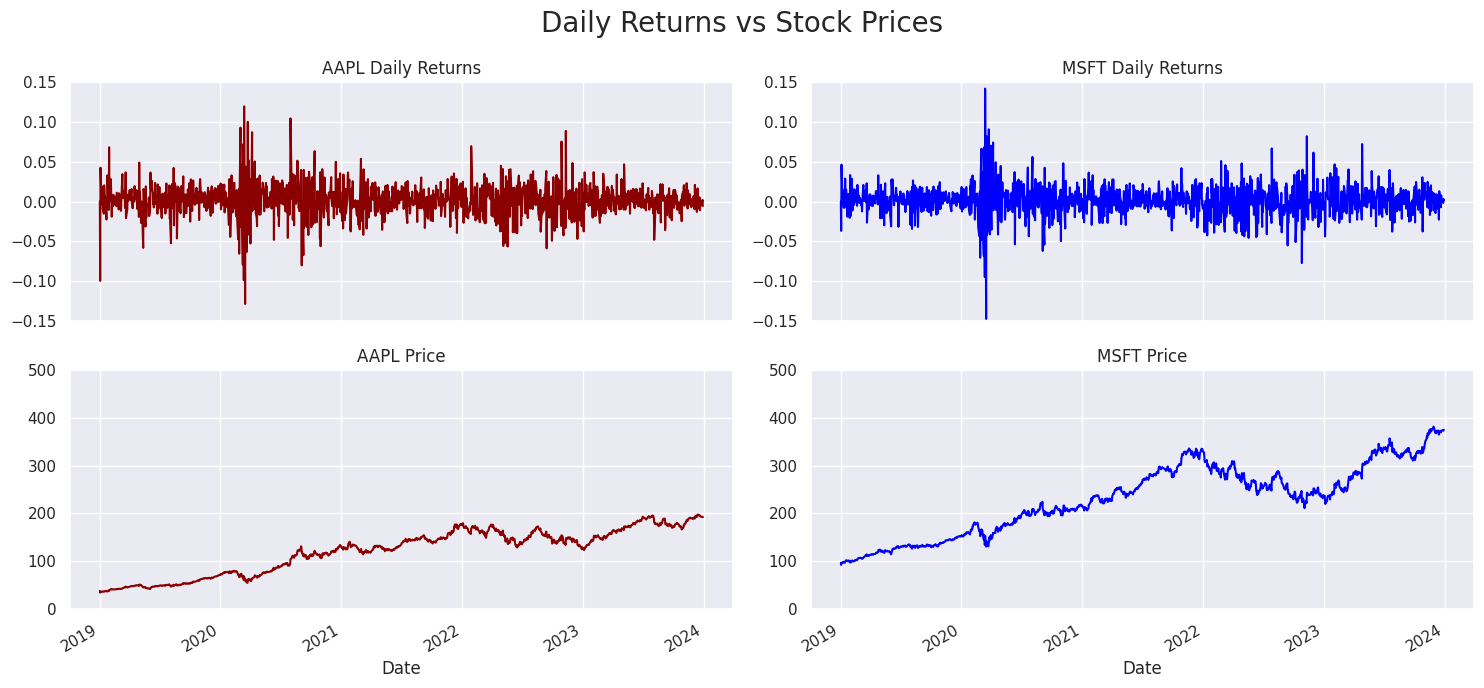

In [18]:
stocknames = ['AAPL','MSFT']
colorlist = ['darkred','blue']
fig, ax = plt.subplots(2,2, figsize=(15,7), sharex=True)

for i, stock in enumerate(stocknames):
    daily_returns[stock].plot(ax=ax[0][i], color=colorlist[i])
    ax[0][i].set_title(stock + ' Daily Returns')
    ax[0][i].set_ylim(-0.15, 0.15)

    df[stock].plot(ax=ax[1][i], color=colorlist[i])
    ax[1][i].set_title(stock + ' Price')
    ax[1][i].set_ylim(0, 500)

fig.suptitle('Daily Returns vs Stock Prices', fontsize=20)
plt.tight_layout()

*Daily return statistics*<br>
1- **The Mean** - use this to calculate Annualized Returns <br>
2- **Standard Deviation** - use this to calculate Annualized Volatility <br>
3- **Kurtosis:** tell us about the `tails of the normal distribution`. the measure of Kurtosis tells us how much `different` our histogram is from that traditional normal distribution.<br><br>
<font color='skyblue'>Types of Kurtosis:</font> <br>

> **Fat tails (value is positive)**: means that there are occasional and more frequent that would happen if we had a regular Gaussin distribution. There are frequently large excursions more frequently than if this was a normal distribution. (More occurrences out in the tails than would be expected if it were a normal distribution).<br><br>

> **Skinny tails (value is negative)**: (Many fewer occurrences out on the tails than would be expected if it were a normal distribution).<br><br>

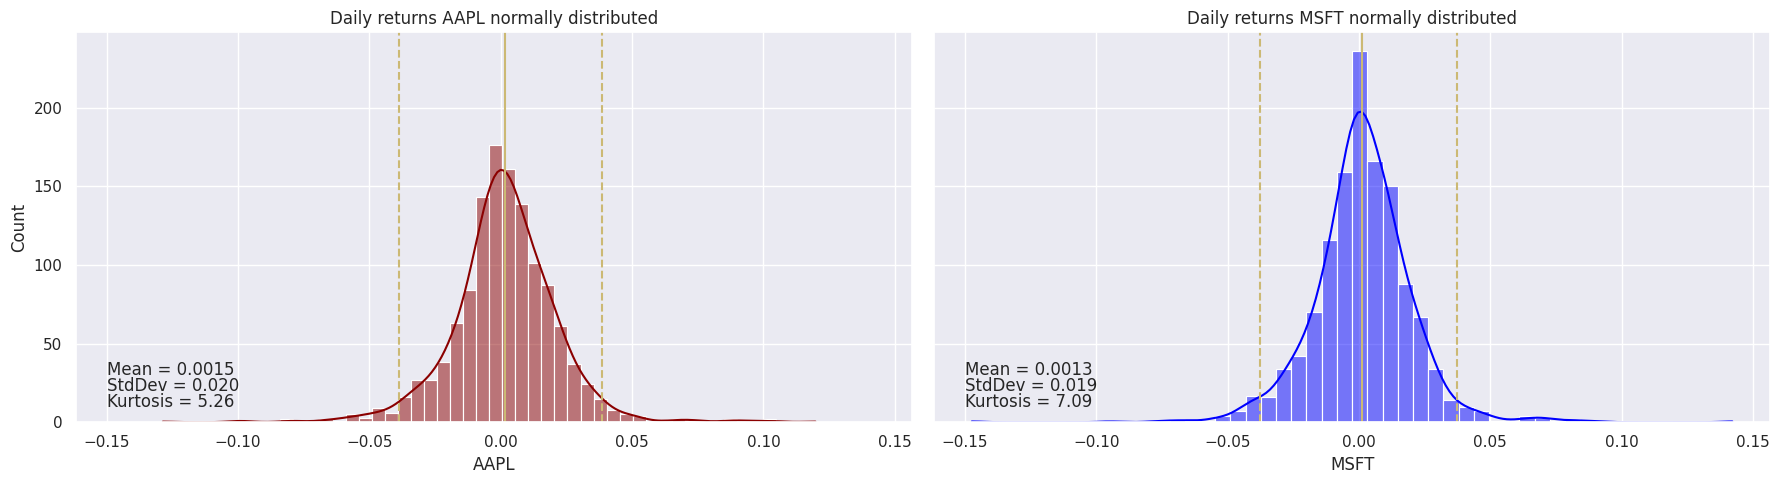

In [19]:
stocknames = ['AAPL','MSFT']
colorlist = ['darkred','blue']
fig, ax = plt.subplots(1,2, figsize=(18,5), sharex=True, sharey=True)

for i, stock in enumerate(stocknames):
    sns.histplot(daily_returns[stock], bins=50, kde=True, color=colorlist[i], ax=ax[i])
    ax[i].set_title('Daily returns ' + stock + ' normally distributed')
    ax[i].axvline(daily_returns[stock].mean(), c='y')
    ax[i].axvline(np.percentile(daily_returns[stock],97.5), linestyle='--', c='y')
    ax[i].axvline(np.percentile(daily_returns[stock],2.5), linestyle='--', c='y')
    ax[i].text(-0.15, 30, 'Mean = {:.4f}'.format(daily_returns[stock].mean()))
    ax[i].text(-0.15, 20, 'StdDev = {:.3f}'.format(daily_returns[stock].std()))
    ax[i].text(-0.15, 10, 'Kurtosis = {:.2f}'.format(daily_returns[stock].kurtosis()))

plt.tight_layout()

Based on Kurtosis results: There are more occurrences in the tails than that of a standard normal distribution.

---------------------------------------------------------------------

##### We are considering two general properties indicated by the histogram for each stock: 1.**Return** and 2.**Volatility (or risk)**.

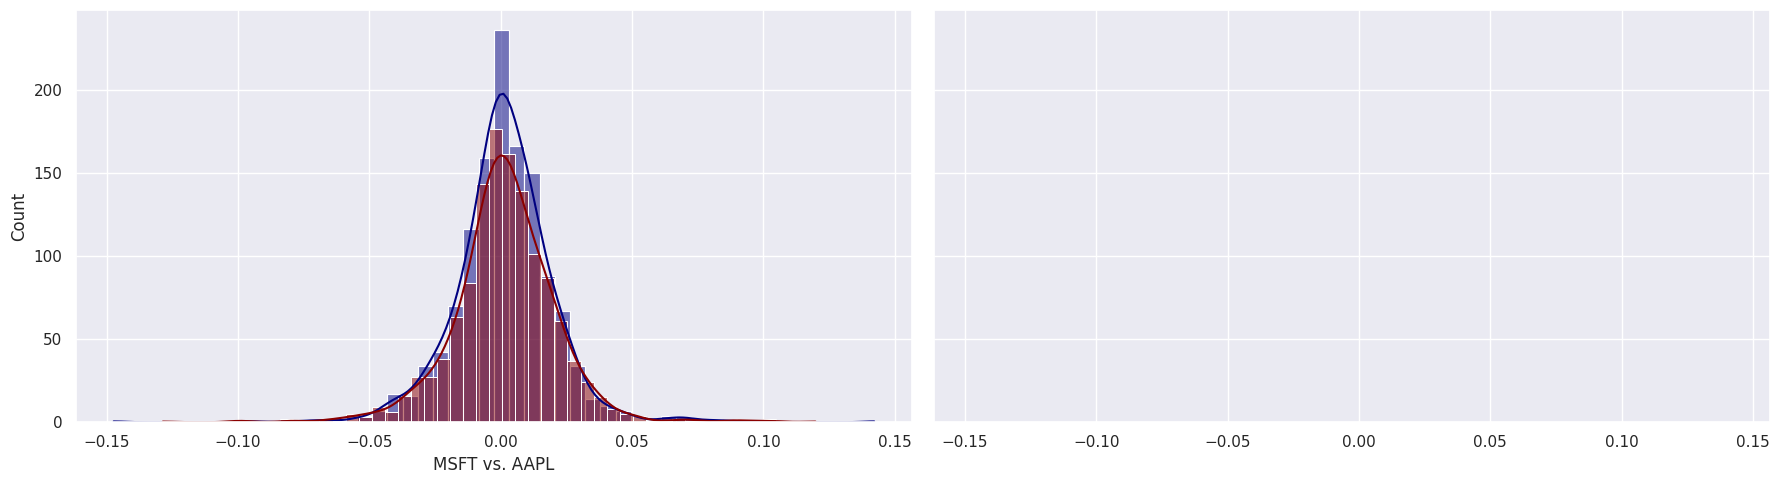

In [20]:
fig, ax = plt.subplots(1,2, figsize=(18,5), sharex=True, sharey=True)

sns.histplot(daily_returns.MSFT, bins=50, color='navy', ax=ax[0], kde=True)
sns.histplot(daily_returns.AAPL, bins=50, color='darkred', ax=ax[0], kde=True, alpha=0.5)
ax[0].set_xlabel('MSFT vs. AAPL')
plt.tight_layout()

In [21]:
df_ret_vol = pd.concat([annualized_returns.to_frame('Annualized Returns'), annualized_volatility.to_frame('Annualized Volatility')], axis=1)
print(df_ret_vol)

      Annualized Returns  Annualized Volatility
AAPL               0.378                  0.322
MSFT               0.320                  0.305


For returns comparison, refer to Normalization plot. For volatility comparison, refer to the above plot (fat/wider means higher volatility)

1. `APPL` has higher return and higher volatility than `SPY` <br>
2. `MSFT` has lower return and slightly lower volatility than `AAPL`

---------------------------------------------

A portfolio is a collection of a number of stocks with different allocations. Before building a portfolio, we need the understand the concept of correlations.

Correlation is a statistical measure that describes the extent to which two variables are related. In the context of investing, correlation refers to the relationship between the prices of two or more assets.

## Correlations

In [22]:
daily_returns.corr()

,AAPL,MSFT
AAPL,1.000,0.759
MSFT,0.759,1.000


[[1.         0.75862178]
 [0.75862178 1.        ]]


<Axes: >

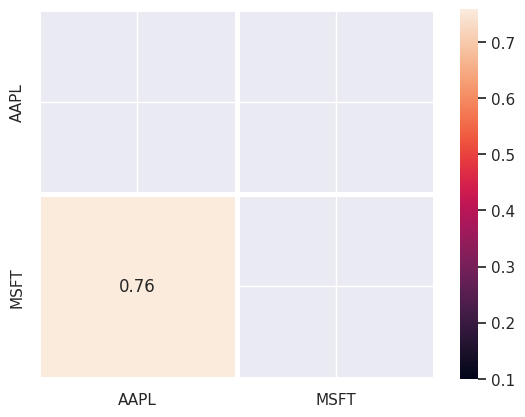

In [23]:
print(np.corrcoef(daily_returns.MSFT, daily_returns.AAPL))

import seaborn as sns

#take the bottom triangle since it repeats itself
mask = np.zeros_like(daily_returns.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(daily_returns.corr(), annot=True, vmin=0.1, mask=mask, linewidths=2.5)

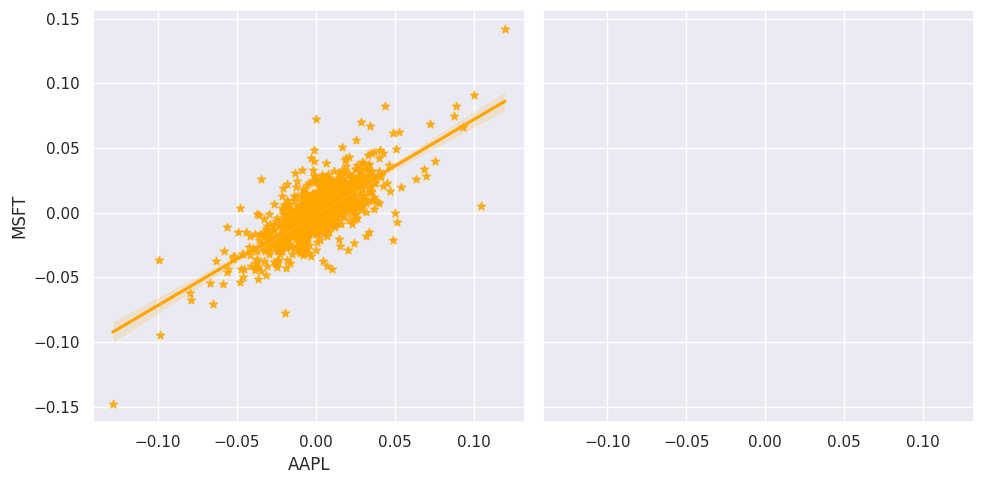

In [24]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
sns.regplot(data=daily_returns, x=daily_returns.AAPL, y=daily_returns.MSFT ,scatter=True, marker='*', ax=ax[0], color='orange')
plt.tight_layout()

*Correlation Coefficient and P-value using SciPy:*

In [25]:
coeff, pval = stats.pearsonr(daily_returns.AAPL, daily_returns.MSFT)
print('CorrCoeff AAPL/MSFT= {:,.0f}'.format(coeff), 'Pval={}'.format(pval))


CorrCoeff AAPL/MSFT= 1 Pval=5.95344139979255e-236


β (Beta = Slop): is how reactive is the market to the stock.<br>
α (Alpha = Intercept): is how well the market performs with respect of stock

$$ŷ = βx + α$$
$$ŷ = Beta * x + Alpha$$
$$ŷ = Slop * x + Intercept$$

*Correlation Coefficient and Pvalue using Numpy:*

In [26]:
beta_AAPL_MSFT = np.polyfit(daily_returns.AAPL, daily_returns.MSFT,1)
print('beta AAPL/MSFT= {}'.format(beta_AAPL_MSFT))


beta AAPL/MSFT= [7.17584428e-01 1.94392778e-04]


When AAPL price goes up 1%, MSFT goes up by 0.7%<br>


In [27]:
slope, intercept, r, p, std_err = stats.linregress(daily_returns.AAPL, daily_returns.MSFT)
print('AAPL/MSFT\n','beta (Slope) = ', slope, '\nalpha (Intercept) = ', intercept, '\nCorrCoeff = ', r, '\nPvalue = ', p)
print('-' * 50)


AAPL/MSFT
 beta (Slope) =  0.7175844282788595 
alpha (Intercept) =  0.0001943927782382315 
CorrCoeff =  0.758621782666095 
Pvalue =  5.953441399789938e-236
--------------------------------------------------


*Correlation Coefficient, Pvalue, and Beta using Stats model (Simple Linear Regression):*

In [28]:
!pip install statsmodels
import statsmodels.api as sm

ml = daily_returns.copy()
ml['intercept'] = 1
lm = sm.OLS(ml.MSFT, ml[['intercept', 'AAPL']])
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     1703.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):          5.95e-236
Time:                        02:50:55   Log-Likelihood:                 3727.1
No. Observations:                1258   AIC:                            -7450.
Df Residuals:                    1256   BIC:                            -7440.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.549      0.583      -0.000       0.001
AAPL           0.7176      0.017     41.265      0.000       0.683       0.752
==============================================================================
Omnibus:                      131.837   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1009.991
Skew:                           0.049   Prob(JB):                    4.82e-220
Kurtosis:                       7.389   Cond. No.                         49.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- When `AAPL` price goes up 1%, `MSFT` goes up by 0.71%<br>
- 57.6% of the variability in `MSFT` price can be explained by `AAPL` price.

------------------------------------------

### <font color='orange'>Cumulative Return Ratio:</font> is the **Profit/Loss** ratio of the stock on a particular period.
**$$ CR (t) = (price[t] / price[0]) - 1$$**
### <center>or</center>
**$$ CR (t) = (price[t] - price[0]) / price[0]$$**

In [29]:
print('Cumulative return of MSFT is: {:.0f} %'.format(((df.iloc[-1]['MSFT'] / df.iloc[0]['MSFT']) - 1) * 100))
print('Cumulative return of AAPL is: {:.0f} %'.format(((df.iloc[-1]['AAPL'] / df.iloc[0]['AAPL']) - 1) * 100))

Cumulative return of MSFT is: 292 %
Cumulative return of AAPL is: 408 %


`MSFT` stock price increased by 148% during the period while `AAPL` stock price increased 241%.<br>


---------------------------------------------
### <font color='orange'>Daily Portfolio Value (DPV):</font> Calculating overall value of a portfolio Day by Day
*Given:*<br>
    - **start value (start_val):** Portfolio Value (the amount of investment)<br>
    - **start date and end date**<br>
    - **allocations (allocs):** allocating the portfolio value on the stocks<br>
    - **Position value (pos_val):** at each day, that's how much that position is worth<br>
    - **Portfolio value (portfolio_daily_returns):** reflects the value each day for our total portfolio
* normailze the prices = $prices / prices[0]$
* allocs = norm * allocations
* pos_val = allocs * start_value
* portfolio_daily_returns = pos_val.sum(axis=1)<br>

*Portfolio Statistics*
* Daily return of portfolio
* Mean and StdDev

*Portfolio Performance Metrics*
* Portfolio Values
* Annualized Returns
* Annualized Volatility
* Sharpe Ratio

# Portfolio 1 vs Portfolio 2

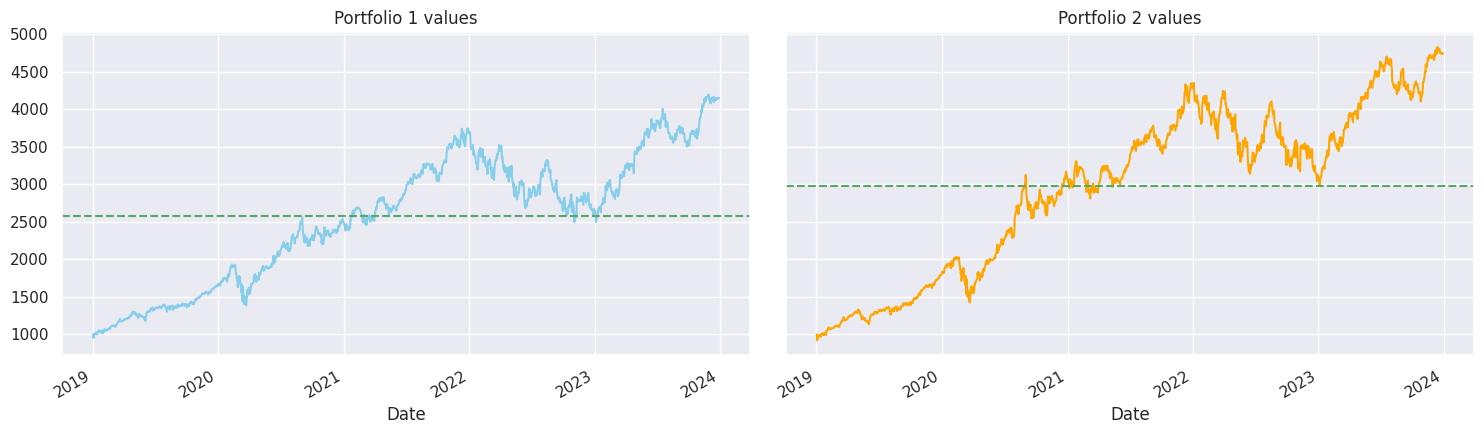

In [30]:
def portval (allocations = [], start_value = 0):
    '''to get daily portfolio value based on allocation'''
    allocs = norm.copy() * allocations
    pos_val = allocs * start_value
    port_val = pos_val.sum(axis=1)
    return port_val

fig, ax = plt.subplots(1, 2, figsize=(15, 4.5), sharex=True, sharey=True)

#assume our start value = $1000
#baseline allocation: 20% MSFT, 80% APPL
port_val1 = portval([0.2, 0.8], 1000)
port_val1.plot(ax=ax[0], color='skyblue')
ax[0].axhline(np.mean(port_val1), linestyle='--', c='g')
ax[0].set_title('Portfolio 1 values')

#new allocation: 70% MSFT, 30% AAPL
port_val2 = portval([0.7, 0.3], 1000)
port_val2.plot(ax=ax[1], color='orange')
ax[1].axhline(np.mean(port_val2), linestyle='--', c='g')
ax[1].set_title('Portfolio 2 values')
plt.tight_layout()

*Portfolio Values*

In [31]:
print('Portfolio 1 Value:  $', round(port_val1[-1], 2))
print('Portfolio 2 Value:  $', round(port_val2[-1], 2))

Portfolio 1 Value:  $ 4149.08
Portfolio 2 Value:  $ 4731.43


*Cumulative Return Ratio of DPV*

In [32]:
cum_return1 = ((port_val1.iloc[-1] / port_val1.iloc[0]) -1) * 100
print('Cumulative return of Portfolio 1 is {:.1f} %'.format(cum_return1))
cum_return2 = ((port_val2.iloc[-1] / port_val2.iloc[0]) -1) * 100
print('Cumulative return of Portfolio 2 is {:.1f} %'.format(cum_return2))

Cumulative return of Portfolio 1 is 314.9 %
Cumulative return of Portfolio 2 is 373.1 %


*Mean and StdDev of DPV (Daily Portfolio Value)*

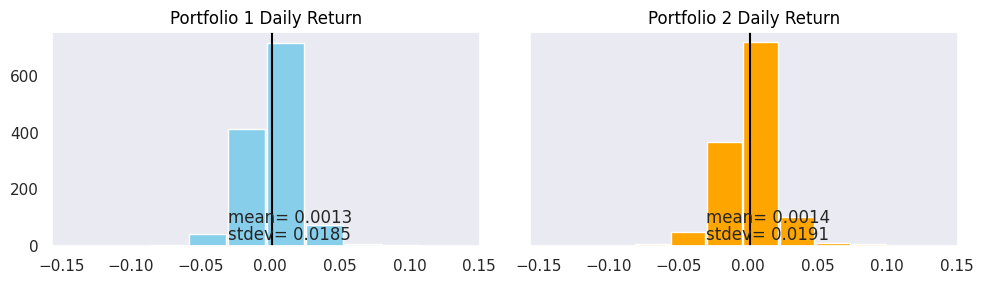

In [33]:
portfolio_daily_returns1 = port_val1.pct_change()
portfolio_daily_returns1.iloc[0] = 0

portfolio_daily_returns2 = port_val2.pct_change()
portfolio_daily_returns2.iloc[0] = 0

fig, ax = plt.subplots(1, 2, figsize=(10,3), sharex=True, sharey=True)

portfolio_daily_returns1.hist(grid=False, rwidth=0.95, ax=ax[0], color='skyblue')
ax[0].axvline(np.mean(portfolio_daily_returns1), c='black')
ax[0].text(-0.03, 80, 'mean= {:.4f}'.format(np.mean(portfolio_daily_returns1)))
ax[0].text(-0.03, 20, 'stdev= {:.4f}'.format(np.std(portfolio_daily_returns1)))
ax[0].set_title('Portfolio 1 Daily Return', c='black')

portfolio_daily_returns2.hist(grid=False, rwidth=0.95, ax=ax[1], color='orange')
ax[1].axvline(np.mean(portfolio_daily_returns2), c='black')
ax[1].text(-0.03, 80, 'mean= {:.4f}'.format(np.mean(portfolio_daily_returns2)))
ax[1].text(-0.03, 20, 'stdev= {:.4f}'.format(np.std(portfolio_daily_returns2)))
ax[1].set_title('Portfolio 2 Daily Return', c='black')
plt.tight_layout()

In [34]:
print('Portfolio 1')
print('Mean (Return) Value = {:.2f}'.format(np.mean(port_val1.iloc[1:])), ' ' , 'Standard Deviation (Volatility) Value = {:.2f}'.format(np.std(port_val1.iloc[1:])))
print('Mean (Return) Ratio = {:.2f}'.format(np.mean(portfolio_daily_returns1) * 100),'%', '  ' , 'Standard Deviation (Volatility) Ratio = {:.2f} %'.format(np.std(portfolio_daily_returns1) * 100))
print('Portfolio 2')
print('Mean (Return) Value = {:.2f}'.format(np.mean(port_val2.iloc[1:])), ' ' ,'Standard Deviation (Volatility) Value = {:.2f}'.format(np.std(port_val2.iloc[1:])))
print('Mean (Return) Ratio = {:.2f}'.format(np.mean(portfolio_daily_returns2) * 100),'%', '  ' , 'Standard Deviation (Volatility) Ratio = {:.2f} %'.format(np.std(portfolio_daily_returns2) * 100))

Portfolio 1
Mean (Return) Value = 2573.85   Standard Deviation (Volatility) Value = 852.96
Mean (Return) Ratio = 0.13 %    Standard Deviation (Volatility) Ratio = 1.85 %
Portfolio 2
Mean (Return) Value = 2971.41   Standard Deviation (Volatility) Value = 1087.81
Mean (Return) Ratio = 0.14 %    Standard Deviation (Volatility) Ratio = 1.91 %


*Annualized Returns*

In [35]:
annualized_returns1 = port_val1.pct_change().mean() * 252
annualized_returns2 = port_val2.pct_change().mean() * 252

print('Portfolio 1 Annualized Returns: ', round(annualized_returns1, 3))
print('Portfolio 2 Annualized Returns: ', round(annualized_returns2, 3))

Portfolio 1 Annualized Returns:  0.329
Portfolio 2 Annualized Returns:  0.358


*Annualized Volatility*

In [36]:
annualized_volatility1 = port_val1.pct_change().std() * np.sqrt(252)
annualized_volatility2 = port_val2.pct_change().std() * np.sqrt(252)

print('Portfolio 1 Annualized Volatility: ', round(annualized_volatility1, 3))
print('Portfolio 2 Annualized Volatility: ', round(annualized_volatility2, 3))

Portfolio 1 Annualized Volatility:  0.294
Portfolio 2 Annualized Volatility:  0.303


We can notice clearly that the return of Portfolio 2 is higher than that of Portfolio 1, but the risk (StdDev) is also higher, and we already expected this (high risk = high returns)


<font color='skyblue'>SHARPE RATIO</font>: <br>is a metric that evaluates risk and returns together, in order to help investors in the selection of such investment that generates higher returns for the optimal risk taken.<br><br>
*<font color='orange'>For comparison:*</font> The higher the sharpe ratio the better <br>
$$Sharpe Ratio = \frac{μ_{PDR} - RFR} {σ_{PDR}}$$
*The Sharpe ratio* can be annualized by multiplying the above ratio by the `square root of 252` as shown below:<br>
$$Sharpe Ratio =\sqrt{252} * \frac{μ_{PDR} - RFR} {σ_{PDR}}$$

References:<br>
[efinancemanagement](https://efinancemanagement.com/calculator/sharpe-ratio-2#:~:text=Sharpe%20ratio%20calculator%20is%20an%20online%20tool%20for,asset%20helps%20in%20generating%20higher%20returns%20or%20not.)<br>
[investopedia](https://www.investopedia.com/terms/s/sharperatio.asp)

In [37]:
portfolio_daily_returns1 = port_val1.pct_change()
SR1 = np.sqrt(252) * np.mean(portfolio_daily_returns1) / np.std(portfolio_daily_returns1)
print('Sharpe Ratio Portfolio 1 = {:.3f}%'.format(SR1))

portfolio_daily_returns2 = port_val2.pct_change()
SR2 = np.sqrt(252) * np.mean(portfolio_daily_returns2) / np.std(portfolio_daily_returns2)
print('Sharpe Ratio Portfolio 2 = {:.3f}%'.format(SR2))

Sharpe Ratio Portfolio 1 = 1.117%
Sharpe Ratio Portfolio 2 = 1.180%


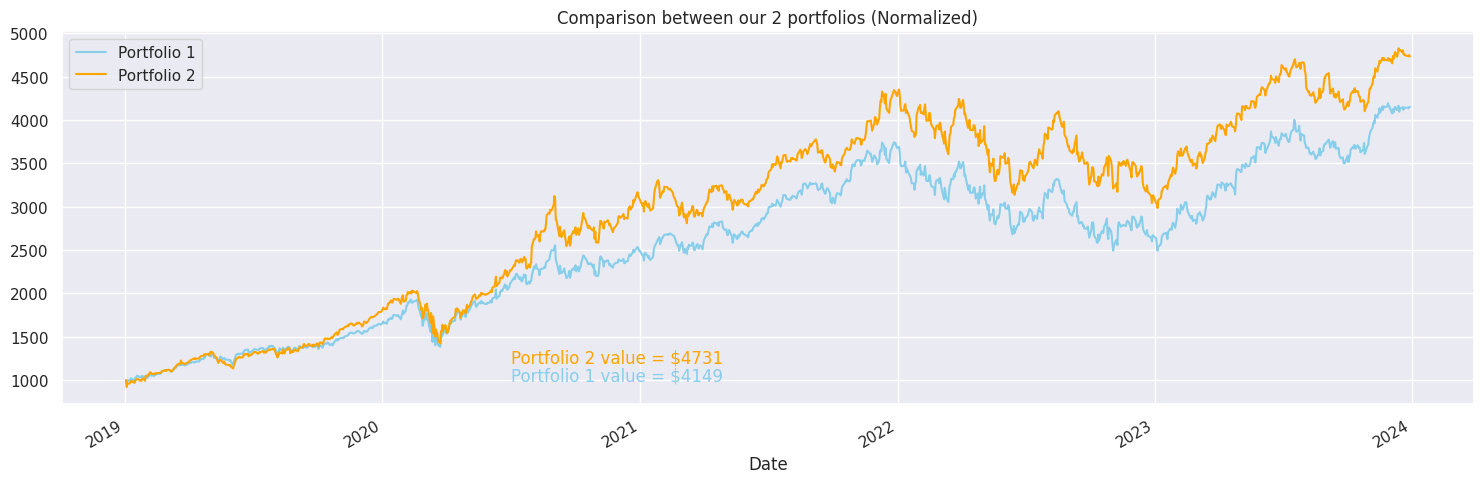

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
port_val1.plot(ax=ax, color='skyblue')
port_val2.plot(ax=ax, color='orange')
plt.legend(['Portfolio 1', 'Portfolio 2'])
plt.title('Comparison between our 2 portfolios (Normalized)')
plt.text('2020-07', 1000, 'Portfolio 1 value = ${:.0f}'.format(port_val1[-1]), color='skyblue')
plt.text('2020-07', 1200, 'Portfolio 2 value = ${:.0f}'.format(port_val2[-1]), color='orange')
plt.tight_layout()

confirming the above result, we can see here the Sharpe Ratio of Portfolio 2 is higher than portfolio 1

-------------------------------------------

# CANDLES CHART



In [39]:
mpf.available_styles()

['binance',
 'binancedark',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'tradingview',
 'yahoo']

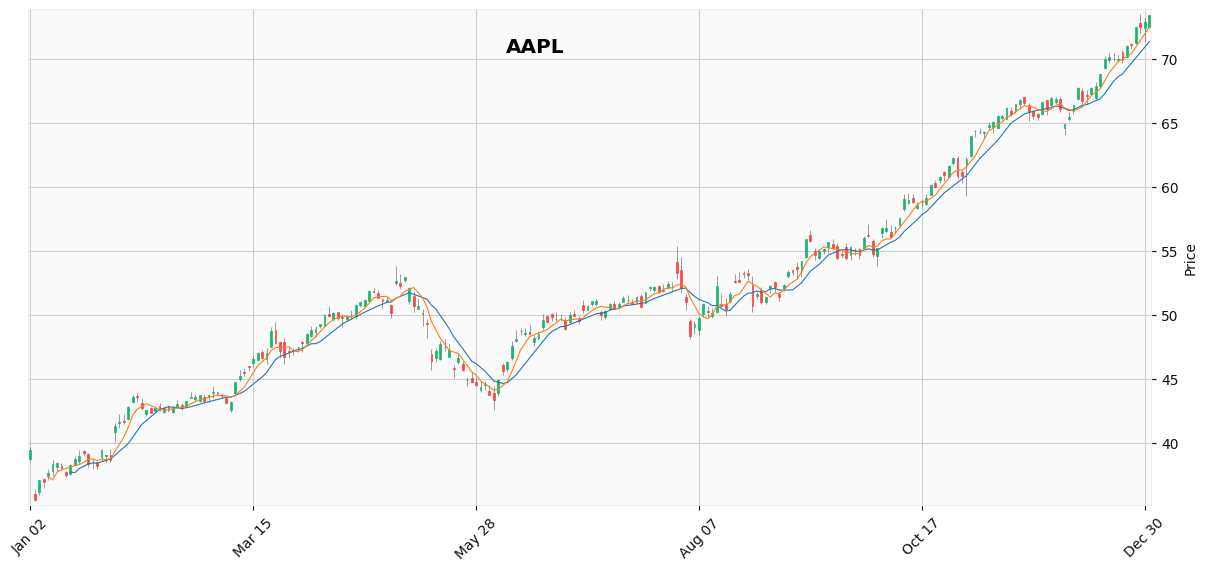

In [40]:
df_aapl = pd.read_csv('stocks_data\AAPL.csv', index_col=0, parse_dates=True)
mask = (df_aapl.index >= '2019-01-01') & (df_aapl.index <= '2019-12-31')
df_aapl = df_aapl.loc[mask]
mpf.plot(df_aapl, type='candle', volume=False, mav=(10,5), title='AAPL', tight_layout=True, figratio=(18,8), style='yahoo')